# Aula 3 - Parte Prática - Redução de Variância e Função Valor

## Introdução

Nesse terceiro notebook vamos aprender ...

### Objetivos:

- 

### Imports

> **Atenção:** não se esqueça de executar todos os `imports` necessários antes prosseguir com o tutorial.

In [1]:
import gym
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

### Política Estocástica em Keras (caso contínuo) 

In [2]:
tfd = tfp.distributions

In [3]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation="tanh", input_shape=(10,)),
    tf.keras.layers.Dense(128, activation="tanh"),
    tf.keras.layers.Dense(10),
    tfp.layers.DistributionLambda(lambda t: tfd.MultivariateNormalDiag(loc=t, scale_diag=[1e-2] * 10))
])

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


In [4]:
inputs = tf.random.normal(shape=(4, 10))
print(inputs)

tf.Tensor(
[[-0.23680624  1.5023457  -1.1089977   0.27807468 -2.2538388  -0.5737803
  -0.20490654  1.2473729  -0.7489533   0.40630406]
 [ 0.4932065  -0.70384246 -0.34450826 -0.34582567 -0.36918163  0.9223177
  -0.03294707  0.80128586 -0.02579398  0.65303445]
 [ 0.10057676 -0.3067007   0.47853523 -0.6956961  -0.2840347  -0.6872966
   0.88367385 -1.5027109  -1.3793855   0.8161227 ]
 [-0.04017695  1.1584165   0.10236181  0.24958104 -0.4439568   0.85326725
  -0.04932357 -0.71357495  0.61898744 -1.2811536 ]], shape=(4, 10), dtype=float32)


In [5]:
dist = model(inputs)
print(dist)

tfp.distributions.MultivariateNormalDiag("sequential_distribution_lambda_MultivariateNormalDiag", batch_shape=[4], event_shape=[10], dtype=float32)


In [6]:
sample = dist.sample()
print(sample)

tf.Tensor(
[[-0.37482095  0.26842874  0.2500399   0.57459664  0.24114588 -0.6014773
   0.24218102 -0.16643134  0.30735442 -0.37810487]
 [-0.1567775  -0.07728397  0.3800133   0.05840343 -0.24018553 -0.20644763
   0.08574593 -0.34349683 -0.35529023 -0.21233612]
 [-0.28345206  0.18179542  0.04384815 -0.07962241 -0.27161238  0.34626088
   0.21313384 -0.17098452  0.29824394  0.5754147 ]
 [ 0.3209522  -0.2566018   0.07487446  0.01460697  0.41561943 -0.09675525
  -0.41220057  0.18668889  0.14782496 -0.19425866]], shape=(4, 10), dtype=float32)


In [7]:
sample_log_prob = dist.log_prob(sample)
print(sample_log_prob)

tf.Tensor([32.065407 31.086979 32.74576  35.238335], shape=(4,), dtype=float32)


In [8]:
def build_continuous_policy(obs_space, action_space, hidden_layers, activation="relu", scale_diag=1e-2):
    Input = tf.keras.Input
    Dense = tf.keras.layers.Dense
    DistributionLambda = tfp.layers.DistributionLambda
    MultivariateNormalDiag = tfd.MultivariateNormalDiag
    
    policy_net_layers = []
    
    policy_net_layers.append(Input(shape=obs_space.shape, name="State"))

    for i, units in enumerate(hidden_layers):
        policy_net_layers.append(Dense(units=units, activation=activation, name=f"Hidden{i+1}"))

    policy_net_layers.append(Dense(units=action_space.shape[0], name="Params"))
    policy_net_layers.append(DistributionLambda(
        lambda t: MultivariateNormalDiag(loc=t, scale_diag=[scale_diag] * action_space.shape[0]),
        name="Action_Distribution_Gaussian"
    ))
                                     
    return tf.keras.Sequential(policy_net_layers)

In [9]:
env = gym.make("MountainCarContinuous-v0")

hidden_layers = [32, 32, 32]
activation = "elu"

policy = build_continuous_policy(env.observation_space, env.action_space, hidden_layers, activation)

batch_size = 10
obs = np.array([env.observation_space.sample() for _ in range(batch_size)])
print(obs.shape)

action_dist = policy(obs)
print(action_dist)

action = action_dist.sample().numpy()
assert action[0] in env.action_space

(10, 2)
tfp.distributions.MultivariateNormalDiag("sequential_1_Action_Distribution_Gaussian_MultivariateNormalDiag", batch_shape=[10], event_shape=[1], dtype=float32)


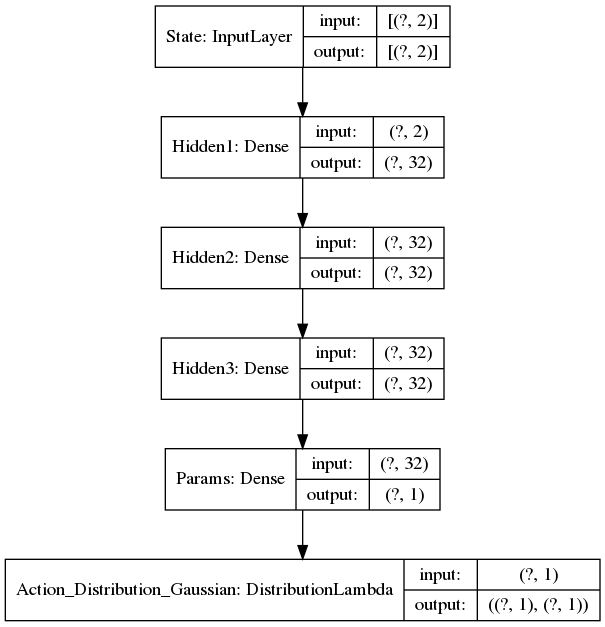

In [10]:
tf.keras.utils.plot_model(policy, show_shapes=True)

## Reward-to-Go 

In [11]:
def compute_reward_to_go(rewards):
    n_episodes = len(rewards)

    returns = []

    for episode in range(n_episodes):
        episode_returns = []
        total_reward = 0.0

        for i in range(len(rewards[episode]) - 1, -1, -1):
            reward = rewards[episode][i]
            total_reward += reward
            episode_returns.append(total_reward)
        
        episode_returns = episode_returns[::-1]
        returns.append(np.array(episode_returns))

    return returns

In [12]:
n_episodes, episode_length = 32, 20
rewards = np.random.uniform(size=[n_episodes, episode_length])

returns = compute_reward_to_go(rewards)

assert len(returns) == n_episodes
assert all(np.allclose(np.cumsum(rewards[i][::-1])[::-1], returns[i]) for i in range(n_episodes))